In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')
# --------------------------------------------------

# --------------------------------------------------
# load datasets
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # pd.get_dummies()
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# decomposition.PCA
from sklearn.decomposition import PCA


# Classifier ---------------------------------------

# estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression # classifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# --------------------------------------------------

# Regressor-----------------------------------------
# estimators
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostError
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# --------------------------------------------------

# stats : R module
from scipy.stats import skew, kurtosis

# model_selection.splitter
from sklearn.model_selection import train_test_split       # function
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold # cross-validator
from sklearn.model_selection import cross_val_score
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV

# **************************************************

# --------------------------------------------------
def check_nan(df):
    nan = df.isna().sum()[df.isna().sum() != 0]
    nan_cols = list(nan.index)
    nan_cnt  = df[nan_cols].isna().sum()
    rate = round(nan_cnt / df.shape[0] * 100, 2)
    nan_df = pd.DataFrame({'NAN_CNT':nan_cnt, 'RATE':rate})
    
    print(nan_df)
    print('-' * 30)
    print('nan_cols count =', len(nan_cols))
    print(nan_cols)
 
    for col in nan_cols:
        print('-' * 30)
        print(df[col].value_counts())
        print('value_counts =', df[col].count(), '/ nan_counts =', df[col].isna().sum())
    
    return nan_cols
# nan_cols = check_nan(df)
# --------------------------------------------------

# --------------------------------------------------
def check_outliers(X_train, features, rate=1.5):
    
    dict = {}
    
    for col in features:
        
        Q1 = np.percentile(X_train[col], 25) 
        Q3 = np.percentile(X_train[col], 75) 
        IQR = Q3 - Q1
        
        min = Q1 - (rate * IQR)
        max = Q3 + (rate * IQR)
        
        idxs = X_train[(X_train[col] < min) | (X_train[col] > max)].index
        
        dict[col] = idxs
        
    return dict
# check_outliers(X_train, 'Insulin')
# --------------------------------------------------

# --------------------------------------------------
def check_object(df):
    object_cols = list(df.dtypes[df.dtypes == 'object'].index)
    print('object_cols count =', len(object_cols))
    for col in object_cols:
        print('-' * 30)
        print(df[col].value_counts())
    return object_cols
# object_cols = encode(df)
# --------------------------------------------------

# --------------------------------------------------
def mapping(df, col, dict):
    dict = {}
    
    for i in range(len(df[col].value_counts().index)):
        dict[df[col].value_counts().index[i]] = i
    
    df['e_' + col] = df[col].map(dict)
    return df['e_' + col].value_counts()
# mapping(df, 'gender')
# --------------------------------------------------

# --------------------------------------------------
def split_xy(df, target, test_size=0.2):
    
    """split X, y & train, test"""
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = split_xy(df, 'Outcome')
# --------------------------------------------------

# --------------------------------------------------
def scores(y_test, y_pred):
    
    """evaluation scores"""
    
    f1        = f1_score         (y_test, y_pred, average='macro')
    accuracy  = accuracy_score   (y_test, y_pred, )
    precision = precision_score  (y_test, y_pred, average='macro')
    recall    = recall_score     (y_test, y_pred, average='macro')
    c_matrix  = confusion_matrix (y_test, y_pred, )
    
    print(
          f'accuracy  = {accuracy:.6f},  '
          f'f1 score  = {f1:.6f},  \n'
          f'precision = {precision:.6f},  '
          f'recall    = {recall:.6f},')
    print(c_matrix)
    
    # plt.figure(figsize=(12, 9))
    # plt.title('confusion matrix')
    # plt.xlabel('Predict')
    # plt.ylabel('Actual')
    # sns.heatmap(c_matrix, annot=True, linewidths=1, cmap='Blues', annot_kws={"size": 14})
    # plt.show()
# --------------------------------------------------

# --------------------------------------------------
def curves(y_test, probas_pred):
        
    FPRS, TPRS, thresholds = roc_curve(y_test, probas_pred[:, 1])
 
    f, ax = plt.subplots(1, 2, figsize=(16, 6))
 
    # settings
    plt.subplot(121)
    plt.title('ROC curve')
    plt.gray()
    plt.xlabel('FPR(1- specificity)')
    plt.ylabel('TPR')
 
    # x, y values
    plt.plot(FPRS, TPRS, label='ROC', linestyle='solid')
    plt.plot([0, 1], [0, 1], label='50%', color='gray', linestyle=':')
    plt.legend()
 
    precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred[:, 1])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
 
    plt.subplot(122)
    plt.title('precision recall curve')
    plt.gray()
    plt.xlabel('threshold')
    plt.ylabel('scores')
 
    # x, y values
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label='precision', linestyle=':')
    plt.plot(thresholds, recalls[:thresholds.shape[0]],    label='recall',    linestyle='--')
    plt.plot(thresholds, f1_scores[:thresholds.shape[0]],  label='f1',        linestyle='solid')
    # valid linestyle = '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    plt.legend()
 
    plt.show()
    
    print('AUC = ', roc_auc_score(y_test, probas_pred[:, 1]))
# --------------------------------------------------
# --------------------------------------------------

# PCA(차원축소, 주성분 분석)

In [2]:
# 이변량 분석(변수 2개)에서, 두 변수 간의 관계가 선형임을 입증하는 것이 상관분석
# 변수 간에 상관관계가 크다면, 다중공선에 걸릴 위험이 큼
# 이 때에 두 변수를 하나로 합치는 방법
# x, y가 선형적인 함수를 그릴 때, 그 함수를 1차원으로 끌어내려 표현
# 원래 변수의 값은 알 수 없음
# 몇 차원이든 연속적으로 사용하면 차원축소가 가능

# 또는 특정 피쳐를 지워도 됨

# drop / PCA 어느 것이 좋은지는 알 수 없음.

## read iris

In [3]:
df = pd.read_csv('./kaggle/toy_iris/Iris.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [4]:
df['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
mapping = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
df['en_Species'] = df['Species'].map(mapping)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
 6   en_Species     150 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 8.3+ KB


In [6]:
df = df.drop(['Species', 'Id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   en_Species     150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [7]:
X = df.drop('en_Species', axis=1)
y = df['en_Species']
X.shape, y.shape

((150, 4), (150,))

## corr

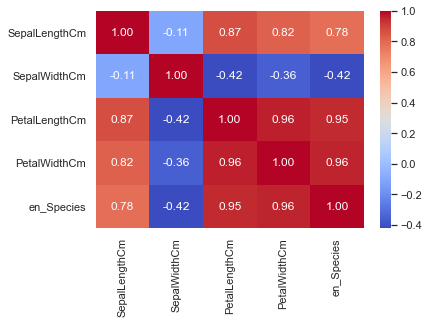

In [8]:
sns.heatmap(df.corr(), fmt='.2f', annot=True, cmap='coolwarm'); plt.show()

# 약한 상관관계 : s_width
# 강한 상관관계 : p_length == p_width / s_length == p_length

## scatter

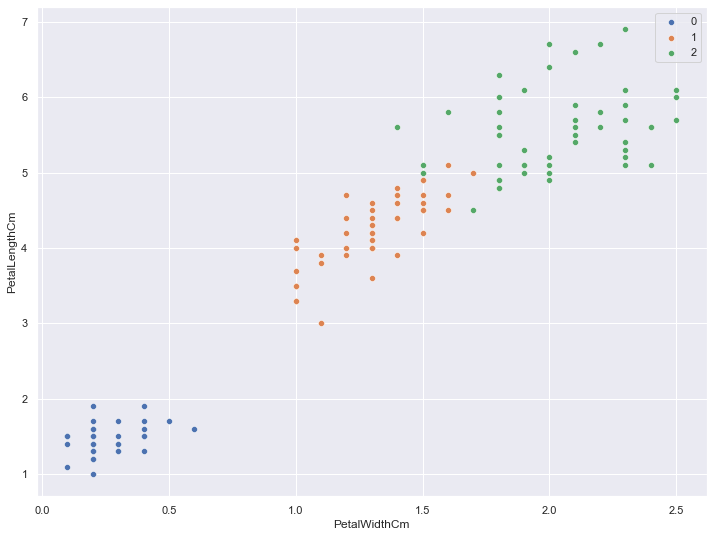

In [9]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.scatterplot(data=df[df['en_Species'] == 0], x='PetalWidthCm', y='PetalLengthCm', label='0')
sns.scatterplot(data=df[df['en_Species'] == 1], x='PetalWidthCm', y='PetalLengthCm', label='1')
sns.scatterplot(data=df[df['en_Species'] == 2], x='PetalWidthCm', y='PetalLengthCm', label='2')
plt.legend()
plt.show()

## pca

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, copy=True, random_state=0) # 2차원으로 축소
res = pca.fit_transform(X)                           # input X, return arr
pca_X = pd.DataFrame(res, columns=['pc1', 'pc2'])    # 공분산/상관분석이 높은 컬럼 우선으로 처리
pca_X['target'] = y
print(pca_X.shape)
pca_X.head()

# pca.explained_variance_ratio_ # pc1, pc2, ... (직교 반복)

(150, 3)


,pc1,pc2,target
0,-2.684207,0.326607,0
1,-2.715391,-0.169557,0
2,-2.889820,-0.137346,0
3,-2.746437,-0.311124,0
4,-2.728593,0.333925,0


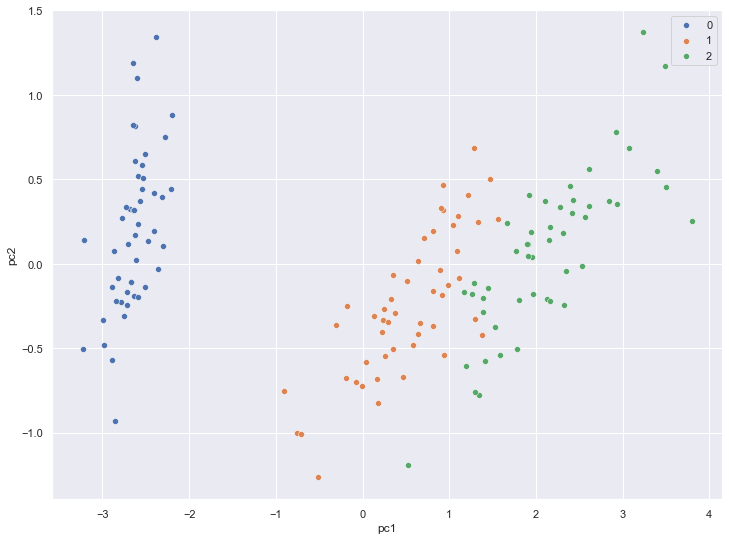

In [11]:
# pca scatter
fig, ax = plt.subplots(figsize=(12, 9))
sns.scatterplot(data=pca_X[pca_X['target'] == 0], x='pc1', y='pc2', label='0')
sns.scatterplot(data=pca_X[pca_X['target'] == 1], x='pc1', y='pc2', label='1')
sns.scatterplot(data=pca_X[pca_X['target'] == 2], x='pc1', y='pc2', label='2')
plt.legend()
plt.show()

## 특정 feature PCA

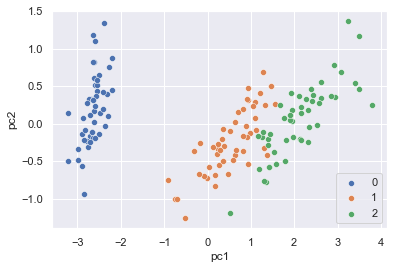

In [12]:
# pca scatter
# fig, ax = plt.subplots(figsize=(12, 9))
sns.scatterplot(data=pca_X[pca_X['target'] == 0], x='pc1', y='pc2', label='0')
sns.scatterplot(data=pca_X[pca_X['target'] == 1], x='pc1', y='pc2', label='1')
sns.scatterplot(data=pca_X[pca_X['target'] == 2], x='pc1', y='pc2', label='2')
plt.legend()
plt.show()

In [13]:
# pca_X = pca_X.drop('target', axis=1)
# pc1 92, pc2 5% / 2개 피쳐만으로도 98% 설명 가능 / 점수는 떨어짐
# 현업 데이터는 학습량이 많기 때문에, 학습 기간을 단축시키기 위함
# 새로운 데이터가 들어오면 일반화했기 때문에 맞힐 확률이 커질 수도 있음
# 다만 차원이 적어지기 때문에 학습은 잘 됨
# 다중공선을 제거할 때 이외에도, 데이터량이 지나치게 많을 때 학습의 속도를 위해 사용
pca.explained_variance_ratio_

array([0.92461621, 0.05301557])

## PCA 전후 score

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y)

model = RandomForestClassifier(random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probas_pred = model.predict_proba(X_test)

scores(y_test, y_pred)

accuracy  = 0.933333,  f1 score  = 0.932660,  
precision = 0.944444,  recall    = 0.933333,
[[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]


In [15]:
pca_X = pca_X.drop('target', axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(pca_X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y)

model = RandomForestClassifier(random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probas_pred = model.predict_proba(X_test)

scores(y_test, y_pred)

accuracy  = 0.966667,  f1 score  = 0.966583,  
precision = 0.969697,  recall    = 0.966667,
[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]


# regression

## read boston house price

In [17]:
dataset = datasets.load_boston()
dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [18]:
df = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
df['target'] = dataset['target']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [19]:
# feature description

# crim	  자치시(town)별 1인당 범죄율
# zn	  25,000 평방 피트를 초과하는 거주지역의 비율
# indus	  비소매상업지역이 차지하고 있는 토지의 비율
# chas	  찰스강의 경계에 위치한 경우는 1, 아니면 0
# nox	  10ppm 당 농축 일산화질소
# rm	  주택 1가구당 평균 방의 수
# age	  1940년 이전에 건축한 소유주택 비율
# dis	  보스톤 직업센터까지의 접근성 지수
# rad	  방사형 도로까지의 접근성 지수
# tax	  10,000 달러당 재산세율
# ptratio 자치시(town)별 학생/교사 비율
# b       자치시(town)별 흑인의 비율
# lstat	  모집단의 하위 계층의 비율
# medv	  본인 소유의 주택가격 중앙값(단위 $1000)

# https://www.kaggle.com/vikrishnan/boston-house-prices

## hist

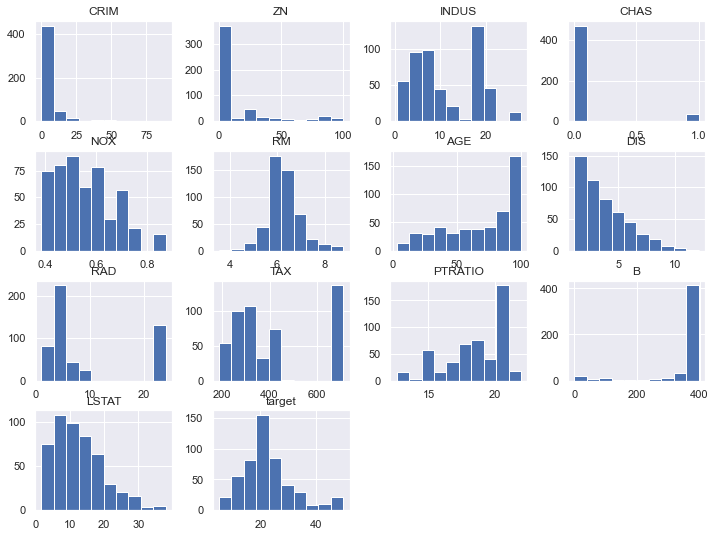

In [20]:
df.hist(figsize=(12, 9)); plt.show()

In [ ]:
##

In [26]:
# outlier, scale 필수 : 분류보다 회귀는 outlier/scale의 영향이 큼
# outlier가 있다면, 편중된 학습을 하기 때문에 반드시 처리

# scalers : MinMax, Standard, Robust
# skew() : 왜도 확인
# Log 변환(0 ~ 1) : feature에 음수(-)가 없을 경우에만 사용, 회귀에서 자주 사용하는 scalerㅠ
# 모델
# L1 규제(Lasso) : x * |w| , w의 절대값, w = 0, 회귀계수를 0으로 만듦, 중요도 낮은 feature 제거 효과
# L2 규제(Ridge): x * w^2 , w의 제곱값, w = 1, 회귀계수를 0에 가깝게 만듦, feature가 없어지지는 않음
# ElasticNet, XGBoostRegressor, LightGBMRegressor, TreeRegressor
# LogisticRegressor : classification (주의)
# MSE(잔차 제곱들의 평균) : metrics -- RMSL(루트), RMSLE(로그), MAE(절대값), Logloss 등 파생

## metrics ver 01

In [28]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [35]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), 
          DecisionTreeRegressor(), XGBRegressor(), LGBMRegressor()]

for model in models:
    print(model.__class__.__name__)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MES  =', mse)
    print('RMSE = ', rmse)
    print('-' * 30)

LinearRegression
MES  = 33.448979997676524
RMSE =  5.783509315085134
------------------------------
Ridge
MES  = 34.231606110615374
RMSE =  5.850778248285896
------------------------------
Lasso
MES  = 41.700096799949
RMSE =  6.457561211475196
------------------------------
ElasticNet
MES  = 40.6653320776942
RMSE =  6.376937515586475
------------------------------
DecisionTreeRegressor
MES  = 35.945686274509804
RMSE =  5.995472147755321
------------------------------
XGBRegressor
MES  = 21.366958008898255
RMSE =  4.622440698256523
------------------------------
LGBMRegressor
MES  = 24.498696726728348
RMSE =  4.949615816073845
------------------------------


## skew, kurt

In [59]:
skew_arr = skew(df)
kurt_arr = kurtosis(df)

sk_df = pd.DataFrame([skew_arr, kurt_arr], index=['skew', 'kurt'], columns=df.columns).T
sk_df

,skew,kurt
CRIM,5.207652,36.752786
ZN,2.219063,3.979949
INDUS,0.294146,-1.233218
CHAS,3.395799,9.531453
NOX,0.727144,-0.075864
RM,0.402415,1.861027
AGE,-0.597186,-0.970014
DIS,1.008779,0.471299
RAD,1.001833,-0.870521
TAX,0.667968,-1.142985


<AxesSubplot:>

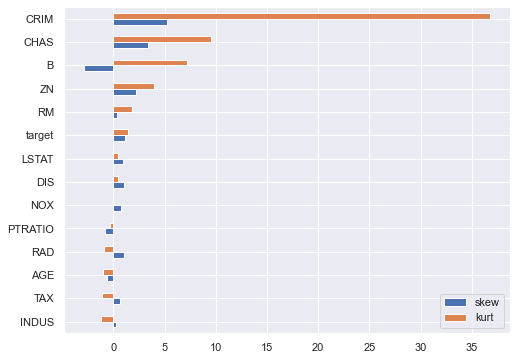

In [83]:
sk_df.sort_values(by='kurt', ascending=True).plot(kind='barh', figsize=(8, 6))
# skew (+) : 왼쪽 치우침(CRIM)
# skew (0) : 정규분포
# skew (-) : 오른쪽 치우침(B)
# kurt (+) : 정규분포보다 뾰족함
# kurt (0) : 정규분포
# kurt (+) : 정규분포보다 납작함

In [85]:
dict = {'skew':skew_arr, 'kurt':kurt_arr}
pd.DataFrame(dict, index=df.columns)

,skew,kurt
CRIM,5.207652,36.752786
ZN,2.219063,3.979949
INDUS,0.294146,-1.233218
CHAS,3.395799,9.531453
NOX,0.727144,-0.075864
RM,0.402415,1.861027
AGE,-0.597186,-0.970014
DIS,1.008779,0.471299
RAD,1.001833,-0.870521
TAX,0.667968,-1.142985


In [ ]:
# model = XGBRegressor(n_estimators=, max_depth=, learning_rate=, 
#                      booster=, n_jobs=, gamma=, reg_alpah=, reg_lambda=, random_state=)

model = XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=0)
